In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display the first few rows of the train dataset
train_df.head()

,id,date_of_birth,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target
0,1,1993-03-14,1,0.036495,0.208897,2400,6,2,0,0,570,817,0
1,2,1966-09-27,1,0.023423,0.260438,2200,6,1,0,0,741,756,0
2,3,1931-01-11,2,0.027205,0.335922,3000,6,1,0,1,805,779,0
3,4,1953-01-07,1,0.009141,0.353779,2100,2,4,0,0,573,829,0
4,5,1943-11-17,0,0.068424,0.314966,2500,2,3,0,0,833,629,0


In [2]:
train_df.shape

(20839, 13)

In [3]:
test_df.shape

(1000, 12)

# Data Cleaning and Exploratory Data Analysis (EDA)

In [4]:
# Check for duplicates
print('Number of duplicate entries:', train_df.duplicated().sum())

Number of duplicate entries: 0


In [5]:
train_df.dtypes

id                            int64
date_of_birth                object
number_dependants             int64
credit_utilization          float64
debt_to_income_ratio        float64
monthly_income                int64
number_open_credit_lines      int64
number_open_loans             int64
number_90_days_past_due       int64
number_charged_off            int64
score1                        int64
score2                        int64
target                        int64
dtype: object

In [6]:
# Descriptive statistics for numerical features
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,20839.0,10923.946878,6295.585008,1.000000e+00,5482.000000,10929.000000,16366.500000,21839.000000
number_dependants,20839.0,0.483421,0.719653,-1.000000e+00,0.000000,0.000000,1.000000,6.000000
credit_utilization,20839.0,0.048159,0.045717,3.932283e-07,0.014367,0.034783,0.067895,0.538702
debt_to_income_ratio,20839.0,0.333507,0.117332,2.938556e-02,0.247782,0.325432,0.411210,0.801838
monthly_income,20839.0,2290.772110,320.090288,2.000000e+03,2100.000000,2200.000000,2400.000000,5000.000000
number_open_credit_lines,20839.0,4.997745,2.248021,0.000000e+00,3.000000,5.000000,6.000000,15.000000
number_open_loans,20839.0,2.027497,1.431671,0.000000e+00,1.000000,2.000000,3.000000,9.000000
number_90_days_past_due,20839.0,0.098901,0.314963,0.000000e+00,0.000000,0.000000,0.000000,3.000000
number_charged_off,20839.0,0.098901,0.315420,0.000000e+00,0.000000,0.000000,0.000000,3.000000
score1,20839.0,669.511637,98.005767,5.000000e+02,584.000000,669.000000,755.000000,839.000000


In [7]:
# Descriptive statistics for categorical features
train_df.describe(include='object').T

,count,unique,top,freq
date_of_birth,20839,14295,1974-10-18,8


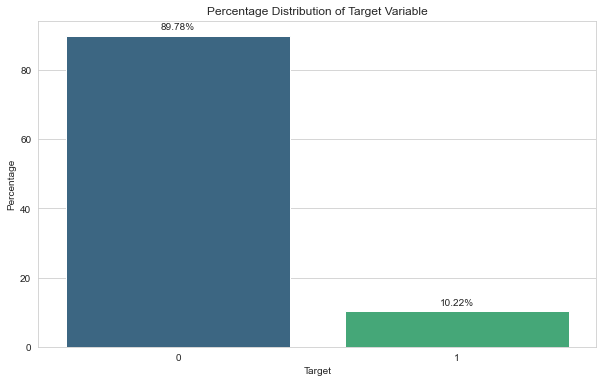

In [8]:
# Calculate the percentage distribution
target_counts = train_df['target'].value_counts(normalize=True) * 100
target_counts = target_counts.reset_index()
target_counts.columns = ['target', 'percentage']

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='target', y='percentage', data=target_counts, palette='viridis')

# Annotate with the percentage
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f') + '%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.title('Percentage Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Percentage')
plt.show()

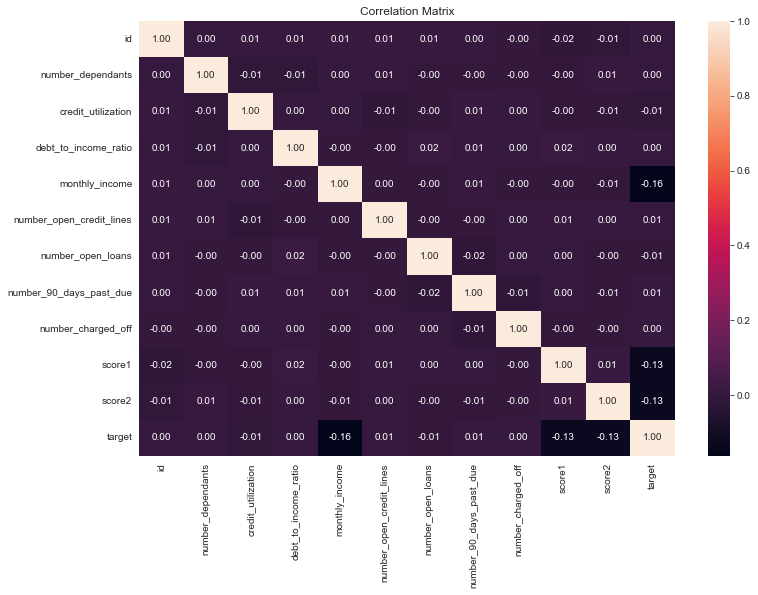

In [9]:
# Correlation matrix to understand the relationships between features
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.corr(), annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

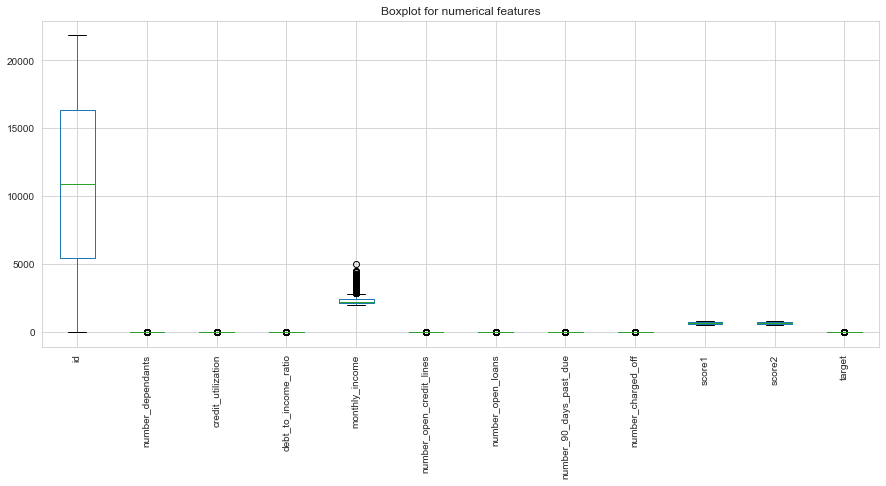

In [10]:
# We will also check for any potential outliers in the numerical features
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
train_df[numerical_features].boxplot(figsize=(15, 6))
plt.title('Boxplot for numerical features')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing and Feature Engineering

To prepare our data for modeling, we need to address the outliers and scale our numerical features. We also need to convert the date_of_birth to a more useful numerical feature, such as age, which might have a more direct relationship with the likelihood of defaulting on a loan.

In [11]:
# Convert 'date_of_birth' to age
train_df['age'] = (pd.to_datetime('today').normalize() - pd.to_datetime(train_df['date_of_birth'])).dt.days // 365
test_df['age'] = (pd.to_datetime('today').normalize() - pd.to_datetime(test_df['date_of_birth'])).dt.days // 365
train_df.drop('date_of_birth', axis=1, inplace=True)
test_df.drop('date_of_birth', axis=1, inplace=True)

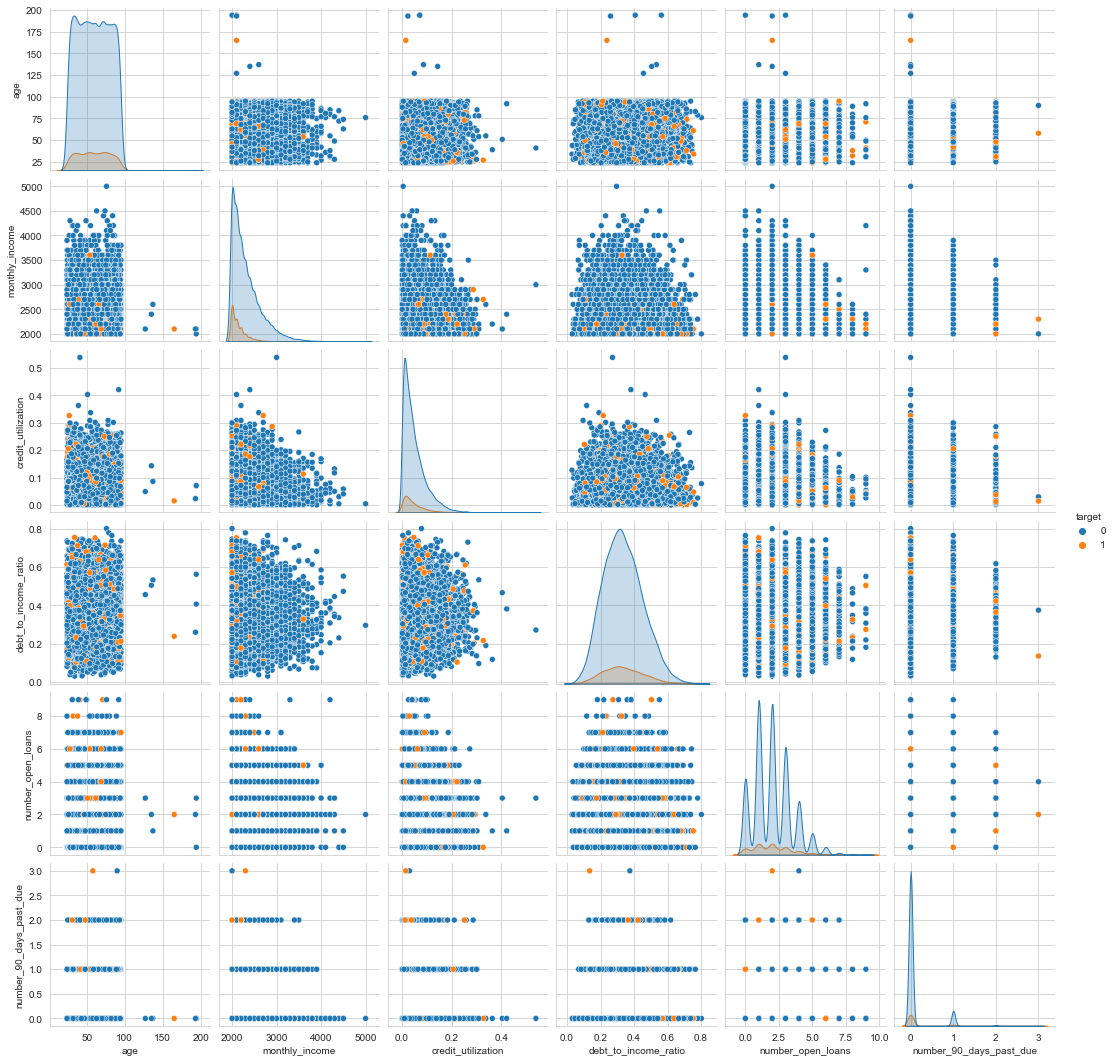

In [12]:
# Pairplot for selected features
sns.pairplot(train_df, vars=['age', 'monthly_income', 'credit_utilization', 'debt_to_income_ratio', 'number_open_loans', 'number_90_days_past_due'], hue='target')
plt.show()

In [13]:
# Feature Engineering
train_df['loan_to_credit_ratio'] = train_df['number_open_loans'] / train_df['number_open_credit_lines']
train_df['credit_to_income_ratio'] = train_df['credit_utilization'] / train_df['monthly_income']
train_df['loan_to_income_ratio'] = train_df['number_open_loans'] / train_df['monthly_income']
train_df['dependant_to_income_ratio'] = train_df['number_dependants'] / train_df['monthly_income']

test_df['loan_to_credit_ratio'] = test_df['number_open_loans'] / test_df['number_open_credit_lines']
test_df['credit_to_income_ratio'] = test_df['credit_utilization'] / test_df['monthly_income']
test_df['loan_to_income_ratio'] = test_df['number_open_loans'] / test_df['monthly_income']
test_df['dependant_to_income_ratio'] = test_df['number_dependants'] / test_df['monthly_income']


In [13]:
len(train_df)

20839

In [14]:
# Replace infinity values resulted from division by zero with nan to handle later
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
len(train_df)

20839

In [16]:
# Check for missing values in the train data
missing_values_train = train_df.isnull().sum()
missing_values_train = missing_values_train[missing_values_train > 0]
print("Missing values in training data:", missing_values_train)

# Check for missing values in the test data
missing_values_test = test_df.isnull().sum()
missing_values_test = missing_values_test[missing_values_test > 0]
print("Missing values in test data:", missing_values_test)

Missing values in training data: Series([], dtype: int64)
Missing values in test data: Series([], dtype: int64)


In [18]:
# Handle missing values if any
# For this example, we'll fill missing values with the median of the column
for column in missing_values_train.index:
    median_value = train_df[column].median()
    train_df[column].fillna(median_value, inplace=True)
    test_df[column].fillna(median_value, inplace=True)

In [17]:
#drop the id column 
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [18]:
train_df.head()

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,target,age
0,1,0.036495,0.208897,2400,6,2,0,0,570,817,0,30
1,1,0.023423,0.260438,2200,6,1,0,0,741,756,0,57
2,2,0.027205,0.335922,3000,6,1,0,1,805,779,0,92
3,1,0.009141,0.353779,2100,2,4,0,0,573,829,0,70
4,0,0.068424,0.314966,2500,2,3,0,0,833,629,0,80


In [19]:
# # Feature Scaling
# # Scale the features using StandardScaler
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_data_scaled = scaler.fit_transform(train_df.drop('target', axis=1))
# test_data_scaled = scaler.transform(test_df)

# # Convert the scaled arrays back to dataframes
# train_data_scaled = pd.DataFrame(train_data_scaled, columns=train_df.drop('target', axis=1).columns)
# test_data_scaled = pd.DataFrame(test_data_scaled, columns=test_df.columns)

# # Display the first few rows of the scaled train dataset
# train_data_scaled.head()

,number_dependants,credit_utilization,debt_to_income_ratio,monthly_income,number_open_credit_lines,number_open_loans,number_90_days_past_due,number_charged_off,score1,score2,age,loan_to_credit_ratio,credit_to_income_ratio,loan_to_income_ratio,dependant_to_income_ratio
0,0.717834,-0.255152,-1.062060,0.341249,0.445850,-0.019206,-0.314016,-0.313561,-1.015389,1.497948,-1.416093,-0.331562,-0.299400,-0.102504,0.627748
1,0.717834,-0.541092,-0.622771,-0.283590,0.445850,-0.717708,-0.314016,-0.313561,0.729448,0.879320,-0.105111,-0.618735,-0.521120,-0.686410,0.745339
2,2.107425,-0.458349,0.020583,2.215765,0.445850,-0.717708,-0.314016,2.856893,1.382486,1.112573,1.594310,-0.618735,-0.597865,-0.873259,1.403846
3,0.717834,-0.853476,0.172772,-0.596009,-1.333536,1.377797,-0.314016,-0.313561,-0.984778,1.619646,0.526103,2.540162,-0.827164,1.549116,0.812533
4,-0.671757,0.443271,-0.158033,0.653668,-1.333536,0.679295,-0.314016,-0.313561,1.668190,-0.408643,1.011651,1.678645,0.292089,0.462717,-0.665749


In [20]:
# # Model Training and Validation

# # Split the training data into training and validation sets
# from sklearn.model_selection import train_test_split

# X = train_data_scaled
# y = train_df['target']
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a logistic regression model as a baseline
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix

# # Initialize the Logistic Regression model
# log_reg = LogisticRegression()

# print(log_reg.summary())

# # Fit the model on the training data
# log_reg.fit(X_train, y_train)

# # Predict on the validation set
# y_pred = log_reg.predict(X_val)

# # Evaluate the model
# print('Classification Report:\n', classification_report(y_val, y_pred))
# print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred))

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Assuming train_data_scaled and train_df are defined

# Split the training data into training and validation sets
X = train_data_scaled
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the training data for statsmodels
X_train_sm = sm.add_constant(X_train)
X_val_sm = sm.add_constant(X_val)

# Initialize and fit the logistic regression model using statsmodels
model_sm = sm.Logit(y_train, X_train_sm)
result = model_sm.fit()

# Print the summary
print(result.summary())

# Predict on the validation set
y_pred_sm = result.predict(X_val_sm)
y_pred_class = (y_pred_sm > 0.5).astype(int)  # Converting probabilities to class labels

# Evaluate the model
print('Classification Report:\n', classification_report(y_val, y_pred_class))
print('Confusion Matrix:\n', confusion_matrix(y_val, y_pred_class))


In [21]:
# import statsmodels.api as sm

# # Assuming 'target' is the name of your target variable
# X = train_df.drop('target', axis=1)
# y = train_df['target']

# # Adding a constant to the model (necessary for statsmodels)
# X = sm.add_constant(X)

# # Splitting the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Building and fitting the model
# model = sm.Logit(y_train, X_train)
# result = model.fit()

# # Printing the summary of the model
# print(result.summary())

# # Making predictions on the test set
# predictions = result.predict(sm.add_constant(X_test))
# predictions = np.round(predictions)  # Converting probabilities to class labels (0 or 1)

# # Evaluating the model
# print(classification_report(y_test, predictions))

from sklearn.metrics import accuracy_score

# Assuming 'target' is the name of your target variable
X_train = train_df.drop('target', axis=1)
y_train = train_df['target']

# Adding a constant to the model (necessary for statsmodels)
X_train = sm.add_constant(X_train)

# Building and fitting the model
model = sm.Logit(y_train, X_train)
result = model.fit()

# Printing the summary of the model
print(result.summary())

# Making predictions on the training set
train_predictions = result.predict(X_train)
train_predictions = (train_predictions > 0.5).astype(int)  # Converting probabilities to class labels (0 or 1)

# Evaluating the model
print("Classification Report for Training Data:")
print(classification_report(y_train, train_predictions))

print("Confusion Matrix for Training Data:")
print(confusion_matrix(y_train, train_predictions))

print("Accuracy Score for Training Data:")
print(accuracy_score(y_train, train_predictions))

# Preparing the test data
X_test = sm.add_constant(X_test)

# Making predictions on the test set
predictions = result.predict(X_test)
predictions = np.round(predictions)  # Converting probabilities to class labels (0 or 1)

# Assuming you have the actual y_test (target variable) for the test dataset
print(classification_report(y_test, predictions))

Optimization terminated successfully.
         Current function value: 0.292094
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                20839
Model:                          Logit   Df Residuals:                    20827
Method:                           MLE   Df Model:                           11
Date:                Thu, 09 Nov 2023   Pseudo R-squ.:                  0.1144
Time:                        12:07:47   Log-Likelihood:                -6087.0
converged:                       True   LL-Null:                       -6873.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       10.9051      0.396     27.551      0.000      10.129

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.897835788665483


NameError: name 'X_test' is not defined

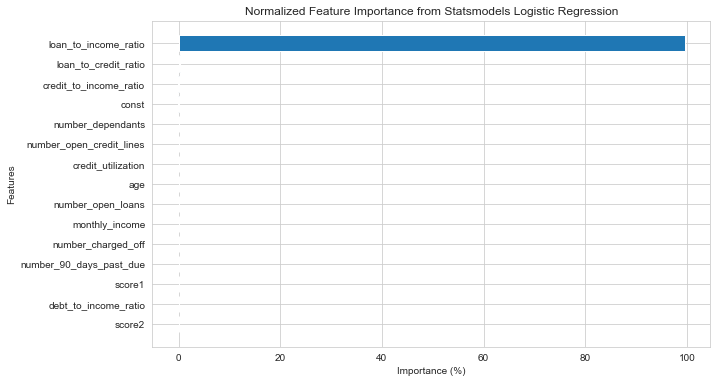

In [28]:
# # Feature Importance from Logistic Regression Coefficients
# feature_importance = log_reg.coef_[0]
# features = X_train.columns

# # Normalize the feature importances to sum up to 100%
# normalized_importance = 100 * (feature_importance / np.sum(abs(feature_importance)))

# # Sorting the normalized feature importances in descending order
# sorted_idx_normalized = np.argsort(abs(normalized_importance))[::-1]

# # Plotting normalized Feature Importance with features on the y-axis
# plt.figure(figsize=(10, 6))
# plt.barh(features[sorted_idx_normalized], normalized_importance[sorted_idx_normalized])
# plt.ylabel('Features')
# plt.xlabel('Importance (%)')
# plt.title('Normalized Feature Importance from Logistic Regression')
# plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
# plt.show()

# Extract coefficients from the model
feature_importance_sm = result.params[1:]  # Excluding the intercept
features_sm = X_train.columns

# Normalize the feature importances to sum up to 100%
normalized_importance_sm = 100 * (feature_importance_sm / np.sum(abs(feature_importance_sm)))

# Sorting the normalized feature importances in descending order
sorted_idx_normalized_sm = np.argsort(abs(normalized_importance_sm))[::-1]

# Plotting normalized Feature Importance with features on the y-axis
plt.figure(figsize=(10, 6))
plt.barh(features_sm[sorted_idx_normalized_sm], normalized_importance_sm[sorted_idx_normalized_sm])
plt.ylabel('Features')
plt.xlabel('Importance (%)')
plt.title('Normalized Feature Importance from Statsmodels Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

# # ROC Curve
# y_pred_proba = log_reg.predict_proba(X_val)[:,1]
# fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
# auc_score = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f"ROC curve (area = {auc_score:.2f})")
# plt.plot([0, 1], [0, 1], linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.legend(loc=4)
# plt.show()

# Get the predicted probabilities
y_pred_proba_sm = result.predict(X_val_sm)

# ROC Curve
fpr_sm, tpr_sm, _ = roc_curve(y_val, y_pred_proba_sm)
auc_score_sm = auc(fpr_sm, tpr_sm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sm, tpr_sm, label=f"ROC curve (area = {auc_score_sm:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Statsmodels Logistic Regression')
plt.legend(loc=4)
plt.show()

NameError: name 'X_val_sm' is not defined

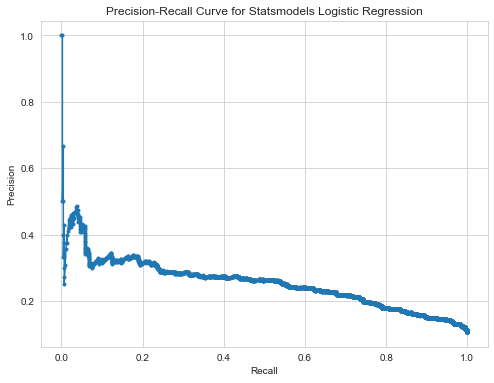

In [24]:
# # Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)

# plt.figure(figsize=(8, 6))
# plt.plot(recall, precision, marker='.')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.show()

# Precision-Recall Curve
precision_sm, recall_sm, _ = precision_recall_curve(y_val, y_pred_proba_sm)

plt.figure(figsize=(8, 6))
plt.plot(recall_sm, precision_sm, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Statsmodels Logistic Regression')
plt.show()

In [30]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the SVM model
svm_clf = SVC(kernel='rbf',random_state=42)

# Fit the model on the training data
svm_clf.fit(X_train, y_train)

# Predict on the validation set
y_pred_svm = svm_clf.predict(X_val)

# Evaluate the SVM model
print('Classification Report for SVM:\n', classification_report(y_val, y_pred_svm))
print('Confusion Matrix for SVM:\n', confusion_matrix(y_val, y_pred_svm))


NameError: name 'X_val' is not defined

In [29]:
import warnings
warnings.filterwarnings('ignore') 

In [30]:
# Train a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_clf.fit(X_train, y_train)

# Predict on the validation set
y_pred_rf = rf_clf.predict(X_val)

# Evaluate the model
print('Classification Report for Random Forest:\n', classification_report(y_val, y_pred_rf))
print('Confusion Matrix for Random Forest:\n', confusion_matrix(y_val, y_pred_rf))

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      3722
           1       0.50      0.01      0.02       446

    accuracy                           0.89      4168
   macro avg       0.70      0.50      0.48      4168
weighted avg       0.85      0.89      0.84      4168

Confusion Matrix for Random Forest:
 [[3717    5]
 [ 441    5]]


In [31]:
from xgboost import XGBClassifier

# Initialize the XGBoost model
xgb_clf = XGBClassifier(random_state=42)

# Fit the model on the training data
xgb_clf.fit(X_train, y_train)

# Predict on the validation set
y_pred_xgb = xgb_clf.predict(X_val)

# Evaluate the XGBoost model
print('Classification Report for XGBoost:\n', classification_report(y_val, y_pred_xgb))
print('Confusion Matrix for XGBoost:\n', confusion_matrix(y_val, y_pred_xgb))


Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      3722
           1       0.41      0.06      0.11       446

    accuracy                           0.89      4168
   macro avg       0.65      0.53      0.53      4168
weighted avg       0.85      0.89      0.85      4168

Confusion Matrix for XGBoost:
 [[3681   41]
 [ 418   28]]


In [34]:
from sklearn.model_selection import RandomizedSearchCV
import joblib

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf_clf, param_distributions=param_grid, 
                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", rf_random.best_params_)

# Save the best model
joblib.dump(rf_random.best_estimator_, 'best_rf_model.pkl')

# Use the best estimator to make predictions
y_pred_rf = rf_random.best_estimator_.predict(X_val)
y_pred_proba_rf = rf_random.best_estimator_.predict_proba(X_val)[:, 1]

# Evaluate the model
print('Classification Report for Random Forest:\n', classification_report(y_val, y_pred_rf))
print('Confusion Matrix for Random Forest:\n', confusion_matrix(y_val, y_pred_rf))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter 

Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 50}
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      3722
           1       1.00      0.00      0.01       446

    accuracy                           0.89      4168
   macro avg       0.95      0.50      0.48      4168
weighted avg       0.90      0.89      0.84      4168

Confusion Matrix for Random Forest:
 [[3722    0]
 [ 444    2]]


In [36]:
from sklearn.metrics import accuracy_score

# After making predictions
y_pred_rf = rf_random.best_estimator_.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred_rf)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8935


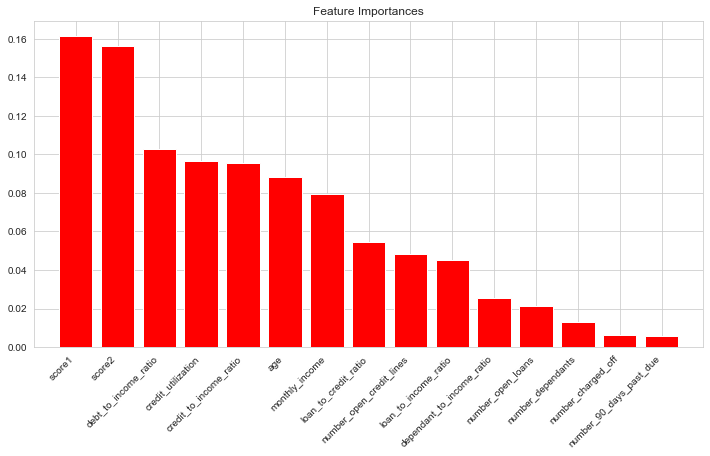

[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.5s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.0s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  12.1s
[CV] END max_depth=10, max_features=aut

[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.6s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   2.9s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.7s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.2s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  14.2s
[CV] END max_depth=20, max_featur

[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   6.3s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   5.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.6s
[CV] END max_depth=None, max_featu

[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   2.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=  11.1s
[CV] END max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=  12.2s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.2s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   6.1s
[CV] END max_depth=None, max_features=

[CV] END max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   2.5s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.6s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  13.8s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=20, max_features=

[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   6.4s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.9s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  13.7s
[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   4.5s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   5.9s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  14.5s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.6s
[CV] END max_depth=None, max_features

[CV] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   6.4s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   5.3s
[CV] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   5.8s
[CV] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  14.2s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.6s
[CV] END max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.0s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=  15.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   8.9s
[CV] END max_depth=20, max_featur

[CV] END max_depth=10, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   6.3s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=  10.8s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  14.8s
[CV] END max_depth=50, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   5.7s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  14.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   5.7s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=  11.3s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   6.6s
[CV] END max_depth=50, max_features=

In [38]:
feature_names = X_train.columns  # Replace with your actual feature names if X_train is not a DataFrame

# Plot feature importances
importances = rf_random.best_estimator_.feature_importances_
# Sort the feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[sorted_indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_indices], rotation=45, ha='right')
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [39]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Initialize the XGBoost model
xgb_clf = XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, 
                                n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
xgb_random.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", xgb_random.best_params_)

# Use the best estimator to make predictions
y_pred_xgb = xgb_random.best_estimator_.predict(X_val)

# Calculate and print accuracy
accuracy = accuracy_score(y_val, y_pred_xgb)
print(f'Accuracy: {accuracy:.4f}')

# Evaluate the model
print('Classification Report for XGBoost:\n', classification_report(y_val, y_pred_xgb))
print('Confusion Matrix for XGBoost:\n', confusion_matrix(y_val, y_pred_xgb))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
Accuracy: 0.8930
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      3722
           1       0.00      0.00      0.00       446

    accuracy                           0.89      4168
   macro avg       0.45      0.50      0.47      4168
weighted avg       0.80      0.89      0.84      4168

Confusion Matrix for XGBoost:
 [[3722    0]
 [ 446    0]]


In [43]:
y_train.value_counts()

0    14988
1     1683
Name: target, dtype: int64

[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=5, min_child_weight=2, n_estimators=100, subsample=0.5; total time=   2.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.5; total time=   6.9s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=500, subsample=0.9; total time=  21.8s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.9; total time=   8.9s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   7.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=200, subsample=0.7; total time=   4.6s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.7; total time=  10.6s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   2.9s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.5; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=500, subsample=0.9; total time=  21.9s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=4, n_estimators=500, subsample=0.9; total time=   8.8s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, subsample=0.5; total time=   7.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=500, subsample=0.5; total time=  10.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, min_child_weight=4, n_estimators=100, subsample=0.9; total time=   3.3s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=400, subsample=0.9; total time=   6.1s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=500, subsample=0.7; total time=  11.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=200, subsample=0.7; total time=   3.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=4, min_child_weight=2, n_estimators=200, subsample=0.5; total time=   3.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.5; total time=   3.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.7; total time=  10.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max

[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=4, min_child_weight=4, n_estimators=200, subsample=0.7; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.5; total time=   6.7s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, subsample=0.5; total time=  16.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=4, min_child_weight=2, n_estimators=300, subsample=0.5; total time=   3.7s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=500, subsample=0.7; total time=  10.3s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=300, subsample=0.9; total time=   7.0s
[CV] END colsample_bytree=0.9, learning_rate=0.3, max_depth=3, min_child_weight=4, n_estimators=500, subsample=0.7; total time=   8.2s
[CV] END colsample_bytree=0.9, learning_rate=0.1, ma

In [47]:
from collections import Counter

# Count the occurrences of each value
counter = Counter(y_pred_rf)

# Calculate and print percentages
total = len(y_pred_rf)
for value, count in counter.items():
    percentage = (count / total) * 100
    print(f'Value {value}: {percentage:.2f}%')

Value 0: 99.95%
Value 1: 0.05%


In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import numpy as np

# Load your datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocessing
# Convert 'date_of_birth' to a numerical feature for both train and test datasets
train_df['date_of_birth'] = pd.to_datetime(train_df['date_of_birth']).map(pd.Timestamp.toordinal)
test_df['date_of_birth'] = pd.to_datetime(test_df['date_of_birth']).map(pd.Timestamp.toordinal)

# Selecting features and target from train dataset
X_train_full = train_df.drop(['id', 'target'], axis=1)
y_train_full = train_df['target']

# Scale the features for both train and test datasets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(test_df.drop('id', axis=1))  # Keep 'date_of_birth' for scaling

# Convert target variable to categorical if it's not binary
y_train_categorical = to_categorical(y_train_full)

# Splitting the train dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_categorical, test_size=0.2, random_state=0)

# Building the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compiling the neural network
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_val, y_val))

# Predicting on the test set
y_test_pred = model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Assuming you want to save these predictions
test_df['predicted_target'] = y_test_pred_classes
test_df.to_csv('test_predictions.csv', index=False)

# If you also want to evaluate on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_classes, y_val_pred_classes)
conf_matrix_val = confusion_matrix(y_val_classes, y_val_pred_classes)


print("Validation Accuracy:", accuracy_val)
print("Training Classification Report:\n", train_report)
print("Validation Confusion Matrix:\n", conf_matrix_val)



Epoch 1/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.3044 - accuracy: 0.8969 - val_loss: 0.3044 - val_accuracy: 0.8920
Epoch 2/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2886 - accuracy: 0.8987 - val_loss: 0.3029 - val_accuracy: 0.8923
Epoch 3/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2848 - accuracy: 0.8995 - val_loss: 0.2991 - val_accuracy: 0.8904
Epoch 4/10
1668/1668 [==============================] - 2s 1ms/step - loss: 0.2832 - accuracy: 0.8993 - val_loss: 0.2958 - val_accuracy: 0.8923
Epoch 5/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2809 - accuracy: 0.8993 - val_loss: 0.2964 - val_accuracy: 0.8920
Epoch 6/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2795 - accuracy: 0.8993 - val_loss: 0.2943 - val_accuracy: 0.8923
Epoch 7/10
1668/1668 [==============================] - 3s 2ms/step - loss: 0.2780 - accuracy: 0.8994 - val_loss: 0.2964 - val_accuracy:

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import numpy as np

# Load your datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Preprocessing
train_df['date_of_birth'] = pd.to_datetime(train_df['date_of_birth']).map(pd.Timestamp.toordinal)
test_df['date_of_birth'] = pd.to_datetime(test_df['date_of_birth']).map(pd.Timestamp.toordinal)

X_train_full = train_df.drop(['id', 'target'], axis=1)
y_train_full = train_df['target']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(test_df.drop('id', axis=1))

y_train_categorical = to_categorical(y_train_full)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_categorical, test_size=0.2, random_state=0)

# Building an optimized neural network
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compiling the neural network
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Training the model with early stopping
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Predicting on the test set
y_test_pred = model.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Save predictions if needed
test_df['predicted_target'] = y_test_pred_classes
test_df.to_csv('test_predictions.csv', index=False)

# Evaluate on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_classes = np.argmax(y_val, axis=1)
accuracy_val = accuracy_score(y_val_classes, y_val_pred_classes)
conf_matrix_val = confusion_matrix(y_val_classes, y_val_pred_classes)
val_report = classification_report(y_val_classes, y_val_pred_classes)

print("Validation Accuracy:", accuracy_val)
print("Validation Confusion Matrix:\n", conf_matrix_val)
print("Validation Classification Report:\n", val_report)


Epoch 1/50
521/521 [==============================] - 3s 3ms/step - loss: 0.7266 - accuracy: 0.5979 - val_loss: 0.5792 - val_accuracy: 0.6643
Epoch 2/50
521/521 [==============================] - 1s 3ms/step - loss: 0.6138 - accuracy: 0.6289 - val_loss: 0.5885 - val_accuracy: 0.6425
Epoch 3/50
521/521 [==============================] - 1s 3ms/step - loss: 0.5923 - accuracy: 0.6456 - val_loss: 0.5839 - val_accuracy: 0.6579
Epoch 4/50
521/521 [==============================] - 2s 3ms/step - loss: 0.5912 - accuracy: 0.6437 - val_loss: 0.5962 - val_accuracy: 0.6351
Epoch 5/50
521/521 [==============================] - 2s 4ms/step - loss: 0.5784 - accuracy: 0.6485 - val_loss: 0.5625 - val_accuracy: 0.6703
Epoch 6/50
521/521 [==============================] - 2s 4ms/step - loss: 0.5792 - accuracy: 0.6542 - val_loss: 0.5829 - val_accuracy: 0.6492
Epoch 7/50
521/521 [==============================] - 2s 4ms/step - loss: 0.5744 - accuracy: 0.6535 - val_loss: 0.5633 - val_accuracy: 0.6761
Epoch 

In [46]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
import plotly.express as px

# Load your dataset
train_df = pd.read_csv('train.csv')

# Convert 'date_of_birth' to age
train_df['age'] = (pd.to_datetime('today').normalize() - pd.to_datetime(train_df['date_of_birth'])).dt.days // 365
train_df.drop('date_of_birth', axis=1, inplace=True)

# Preprocessing
y = train_df['target']

# Drop the 'id' column if it exists
if 'id' in train_df.columns:
    train_df.drop('id', axis=1, inplace=True)

# Keep only numeric columns
train_df = train_df.select_dtypes(include=[np.number])

# Handling missing values
imputer = SimpleImputer(strategy='mean')
train_df_imputed = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)

# Applying Agglomerative Clustering with 4 clusters
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage="ward")
clusters = agg_clustering.fit_predict(train_df_imputed)

# Add cluster information to the DataFrame
train_df['Cluster'] = clusters

# Create a DataFrame to store feature summaries for each cluster
feature_summary = pd.DataFrame()

# Iterate through clusters and calculate feature summaries
for cluster in range(4):
    cluster_data = train_df[train_df['Cluster'] == cluster].drop(columns=['Cluster'])
    cluster_mean = cluster_data.mean()
    cluster_std = cluster_data.std()
    cluster_count = cluster_data.count()

    cluster_summary = pd.DataFrame({
        'Cluster': [cluster] * len(cluster_mean),
        'Feature': cluster_mean.index,
        'Mean': cluster_mean.values,
        'Std': cluster_std.values,
        'Count': cluster_count.values
    })

    feature_summary = pd.concat([feature_summary, cluster_summary], ignore_index=True)

print("Feature Summary for Each Cluster:")
print(feature_summary)


Feature Summary for Each Cluster:
    Cluster                   Feature         Mean         Std  Count
0         0         number_dependants     0.485320    0.719105   3406
1         0        credit_utilization     0.048191    0.046479   3406
2         0      debt_to_income_ratio     0.332828    0.117611   3406
3         0            monthly_income  2762.096301  180.582052   3406
4         0  number_open_credit_lines     5.025543    2.256580   3406
5         0         number_open_loans     2.016148    1.424777   3406
6         0   number_90_days_past_due     0.106283    0.330321   3406
7         0        number_charged_off     0.105402    0.331047   3406
8         0                    score1   679.093365   98.785652   3406
9         0                    score2   662.136524   97.637394   3406
10        0                    target     0.024662    0.155117   3406
11        0                       age    59.381679   20.627184   3406
12        1         number_dependants     0.482213    0.

In [45]:
train_df.columns

Index(['number_dependants', 'credit_utilization', 'debt_to_income_ratio',
       'monthly_income', 'number_open_credit_lines', 'number_open_loans',
       'number_90_days_past_due', 'number_charged_off', 'score1', 'score2',
       'target', 'age', 'Cluster'],
      dtype='object')